Example from: https://chrisorm.github.io/VAE-pyt.html

In [1]:
import torch
from torch import nn
from torch.autograd import Variable

import numpy as np

In [2]:
representation_size = 2
input_size = 4
n_samples = 2000
batch_size = 5

n_samples_per_batch = n_samples//input_size

y = np.array([i for i in range(input_size)  for _ in range(n_samples_per_batch)])

d = np.identity(input_size)
x = np.array([d[i] for i in y], dtype=np.float32)

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.en1 = nn.Linear(input_size, 200)
        self.en_mu = nn.Linear(200, representation_size)
        self.en_std = nn.Linear(200, representation_size)
        self.de1 = nn.Linear(representation_size, 200)
        self.de2 = nn.Linear(200, input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        """Encode a batch of samples, and return posterior parameters for each point."""
        h1 = self.relu(self.en1(x))
        return self.en_mu(h1), self.en_std(h1)
    
    def decode(self, z):
        """Decode a batch of latent variables"""
        
        h2 = self.relu(self.de1(z))
        return self.sigmoid(self.de2(h2))
    
    def reparam(self, mu, logvar):
        """Reparameterisation trick to sample z values. 
        This is stochastic during training,  and returns the mode during evaluation."""
        
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
            
    
    def forward(self, x):
        """Takes a batch of samples, encodes them, and then decodes them again to compare."""
        mu, logvar = self.encode(x.view(-1, input_size))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss(self, reconstruction, x, mu, logvar):
        """ELBO assuming entries of x are binary variables, with closed form KLD."""
        
        bce = torch.nn.functional.binary_cross_entropy(reconstruction, x.view(-1, input_size))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= x.view(-1, input_size).data.shape[0] * input_size

        return bce + KLD
    
    def get_z(self, x):
        """Encode a batch of data points, x, into their z representations."""
        
        mu, logvar = self.encode(x.view(-1, input_size))
        return self.reparam(mu, logvar)

In [9]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
def train(epoch, batches_per_epoch = 501, log_interval=500):
    model.train()
    
    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss(recon_batch, data, mu, logvar)
        loss.backward()
        #train_loss += loss.data[0]
        optimizer.step()
        if (i % log_interval == 0) and (epoch % 5 ==0):
            #Print progress
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, i * batch_size, batch_size*batches_per_epoch,
                loss.data / len(data)))

    print('====> Epoch: {} done!'.format(
          epoch))


def test(epoch, batches_per_epoch=1):
    model.eval()

    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        recon_batch, mu, logvar = model(data)
        if i == 0:
            n = min(data.size(0), 2)
            print(data.view(batch_size, 2,2)[:n])
            print(recon_batch.view(batch_size, 2,2)[:n])

In [19]:
print_examples = False #Change to true if you want to see some examples at each step!
for epoch in range(1, 30):
    train(epoch)
    if print_examples:
        test(epoch)

====> Epoch: 1 done!
====> Epoch: 2 done!
====> Epoch: 3 done!
====> Epoch: 4 done!
Train Epoch: 5 [0/2505]	Loss: 0.065583
Train Epoch: 5 [2500/2505]	Loss: 0.077711
====> Epoch: 5 done!
====> Epoch: 6 done!
====> Epoch: 7 done!
====> Epoch: 8 done!
====> Epoch: 9 done!
Train Epoch: 10 [0/2505]	Loss: 0.111036
Train Epoch: 10 [2500/2505]	Loss: 0.070490
====> Epoch: 10 done!
====> Epoch: 11 done!
====> Epoch: 12 done!
====> Epoch: 13 done!
====> Epoch: 14 done!
Train Epoch: 15 [0/2505]	Loss: 0.071442
Train Epoch: 15 [2500/2505]	Loss: 0.082929
====> Epoch: 15 done!
====> Epoch: 16 done!
====> Epoch: 17 done!
====> Epoch: 18 done!
====> Epoch: 19 done!
Train Epoch: 20 [0/2505]	Loss: 0.102204
Train Epoch: 20 [2500/2505]	Loss: 0.068782
====> Epoch: 20 done!
====> Epoch: 21 done!
====> Epoch: 22 done!
====> Epoch: 23 done!
====> Epoch: 24 done!
Train Epoch: 25 [0/2505]	Loss: 0.072114
Train Epoch: 25 [2500/2505]	Loss: 0.091723
====> Epoch: 25 done!
====> Epoch: 26 done!
====> Epoch: 27 done!
==

In [20]:
data = Variable(torch.from_numpy(x), requires_grad=False)
model.train()
zs = model.get_z(data).data.numpy()

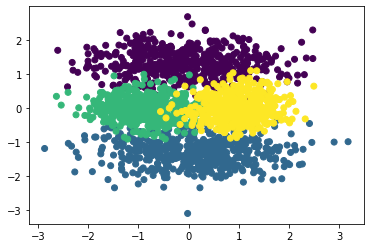

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(zs[:,0], zs[:, 1], c=y)